In [16]:
#Marée Maxime 27361900
#Imports utiles
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.ext.matproj import MPRester
from pymatgen.electronic_structure.bandstructure import*
from pymatgen.electronic_structure.plotter import*

# Téléchargement des fichiers CIF

On peut télécharger directement la structure de bandes électronique avec MPRester via la fonction get_bandstructure_by_material_id()

In [17]:
#Téléchargement du fichier CIF de la structure de bandes électroniques
with MPRester("rzFNAXwVskd5hQE3") as m:
    bandstructure = m.get_bandstructure_by_material_id("mp-961673")

# Structure de bandes électroniques du TiFeTe  

Dans cette section, on représente la structure de bandes électroniques du TiFeTe

J'utilise la classe BSPlotter qui permet de réprésenter la structure de bandes électroniques

<module 'matplotlib.pyplot' from '/usr/local/lib64/python3.6/site-packages/matplotlib/pyplot.py'>

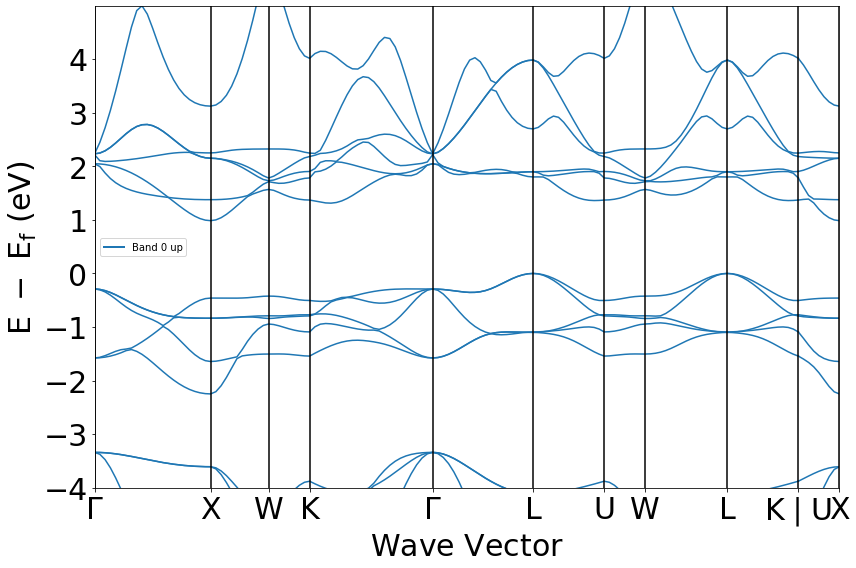

In [18]:
bandplot = BSPlotter(bandstructure)
bandplot.get_plot()

#### Récupération des données utiles pour la suite

Le dictionnaire $\textbf{data}$ est rempli des données de la structure de bandes électroniques.

Le tableau $\textbf{distance}$ détermine les distances entre les vecteurs d'onde sur le graphe.

Le tableau $\textbf{distances}$ contient l'ensemble des points importants situés dans une transition de vecteur d'onde c'est-à-dire tous les points situés entre 2 éléments de distance.

Le dictionnaire $\textbf{energy}$ stocke les énergies pour chaque bande dans des tableaux np.array(nb_bands,kpoints).

In [19]:
### Récup de données 
data = bandplot.bs_plot_data()
distance = data.get('ticks').get('distance') 
distances = data.get('distances') 
energy = data.get('energy') 

# Analyse de la structure de bandes électroniques du TiFeTe

### 1) Détermination de la bande interdite

Pour analyser les informations sur la bande interdite, on va analyser le gap entre la bande de valence et la bande de conduction

In [20]:
bandinter = bandstructure.get_band_gap()
typegap = ""
#On regarde s'il s'agit d'un gap direct ou indirect
if bandinter['direct'] == False :
    typegap = "indirecte"
else :
    typegap = "directe"
    
print("La bande interdite a un gap",typegap,"de",bandinter['energy'],"eV")
print("On observe cette bande interdite quand le vecteur d'onde k évolue dans la direction", bandinter['transition'])

La bande interdite a un gap indirecte de 0.9852000000000007 eV
On observe cette bande interdite quand le vecteur d'onde k évolue dans la direction L-X


### 2) Direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion 

Pour déterminer les bandes de valences extrêmes, on va chercher les bandes qui atteignent les maximum ou les minimum :

- Pour la dernière bande de valence, il s'agit de trouver la bande qui atteint le valence band maximum (VBM)
- Pour la première bande de conduction, il s'agit de trouver la bande qui atteint le conduction band minimum (CBM)

#### Récupération des données utiles

In [21]:
#1) Les numéros des bandes de valences via the valence band maximum (VBM) and the conduction band minimum (CBM)
list_cbm = []
list_vbm = []
for cbm in bandstructure.get_cbm() ['band_index'].items() :
    list_cbm = cbm[1]
for vbm in bandstructure.get_vbm() ['band_index'].items() :
    list_vbm = vbm[1]    

#### 2.1) Détermination de la dernière bande de valence 

Dans le cas de mon matériau, on détecte 2 bandes qui atteignent le valence band maximum (VBM)

In [22]:
print("La première bande de valence atteignant le VBM est la bande",list_vbm[0])
print("L'autre bande de valence atteignant le VBM est la bande",list_vbm[1])

La première bande de valence atteignant le VBM est la bande 13
L'autre bande de valence atteignant le VBM est la bande 14


Or on veut analyser la dernière bande de valence, il s'agit donc de la bande avec l'indice le plus élevé.

La dernière bande de valence pour mon matériau est donc la bande 14

#### 2.2) Détermination de la première bande de conduction

Dans le cas de mon matériau, il y a 1 dernière bande de conduction détectée par le conduction band minimum (CBM)

In [23]:
print("La première bande de conduction est la bande",list_cbm[0])

La première bande de conduction est la bande 15


#### 2.3) Représentation des bandes analysées ci dessus

Text(0.5, 1.0, 'Structure de bandes électroniques du TiFeTe avec la bande interdite')

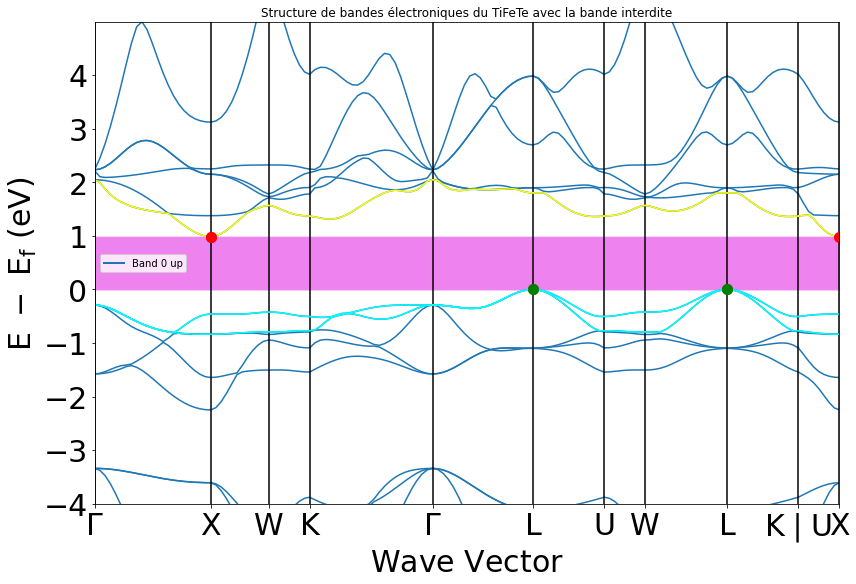

In [26]:
# Pour mettre la structure de bandes sur le graph
bandplot.get_plot()

# Pour mettre en evidence les deux bande de valence atteignant le VBM et la première bande de conduction
for i in range(len(distances)):
    plt.plot(distances[i],energy.get('1')[i][13],'cyan')
    plt.plot(distances[i],energy.get('1')[i][14],'cyan')
    plt.plot(distances[i],energy.get('1')[i][15],'yellow')

vbms = data.get('vbm')
cbms = data.get('cbm')

# Représentation des vbms
for j in range(len(vbms)):
    x, y= vbms[j]
    plt.plot(x, y, 'og', markersize=10)
# Représentation des cbms
for k in range(len(cbms)):
    x, y = cbms[k]
    plt.plot(x ,y ,'or',markersize=10)
    
# Tracer la bande interdite 
plt.fill_between(np.linspace(distance[0], distance[-1], 1000), 0, bandinter.get('energy'), color = "violet")

plt.title('Structure de bandes électroniques du TiFeTe avec la bande interdite')

### 2.4) Les dispersions 

Pour calculer les dispersions, on sait qu'il s'agit de la pente du graphe de structure de bande électronique à savoir le rapport de la variation d'énergie sur la variation de distance : $\frac{\Delta E}{\Delta k}$. 

Ensuite pour calculer les extremas de dispersion, on regarde parmi les pentes calculées et on prend la valeur absolue de la pente la plus élevée pour la dispersion maximale et la valeur absolue de la pente la moins élevée pour la dispersion minimale.

La transition de vecteur d'onde sur laquelle on observera les dispersions permettra de déterminer dans quelle direction a lieu la dispersion.


#### Calcul des pentes de dispersion maximale  et minimale des bandes de valence et de la bande de conduction

In [39]:
def pente(x_abs, y_ord) :
    pente = (abs(y_ord[-1] - y_ord[0]))/(x_abs[-1] - x_abs[0])
    return np.array([x_abs[0],y_ord[0],x_abs[-1],y_ord[-1],pente])

valencep = np.zeros((len(distances),5))
condup = np.zeros((len(distances),5))
condpente = np.zeros(len(distances))
valencepente = np.zeros(len(distances))
 

for j in range(len(distances)) :
    valencep[j] = pente(distances[j],energy.get('1')[j][14])
    condup[j] = pente(distances[j],energy.get('1')[j][15])
    
    #Récupération de l'ensemble des pentes
    condpente[j] = condup[j] [4]
    valencepente[j] = valencep [j] [4]
    
# Déterminer les indices pour la bande de conduction 
# de la pentes maximum (correspondant à la dispersion maximale) et de la pente minimum (correspondant à la dispersion minimale)
condmax = np.argmax(condpente)
condmin = np.argmin(condpente)

# Déterminer les indices pour la dernières bande de valence
# de la pentes maximum (correspondant à la dispersion maximale) et de la pente minimum (correspondant à la dispersion minimale) 
valmax = np.argmax(valencepente)
valmin = np.argmin(valencepente)

#### Représentation de la dispersion maximale 

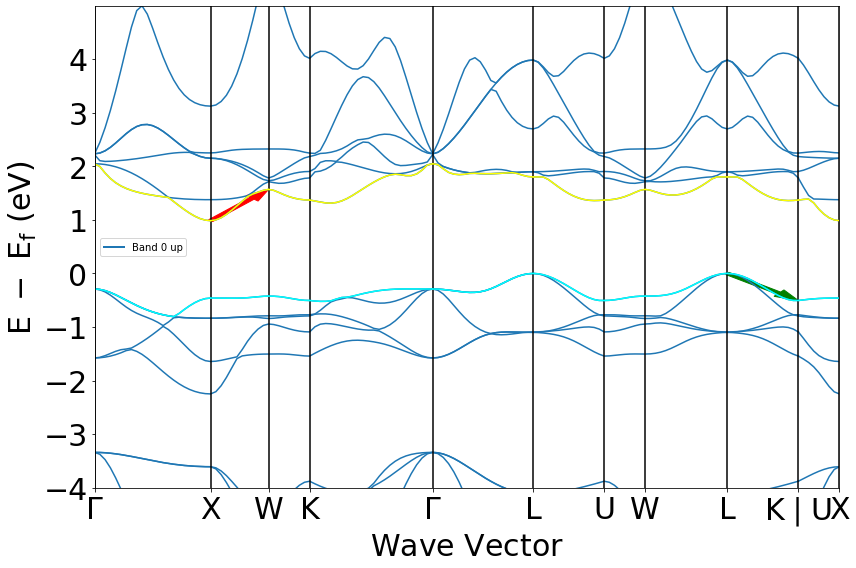

In [40]:
bandplot.get_plot()
conddx = condup[condmax][2] - condup[condmax][0]
conddy = condup[condmax][3] - condup[condmax][1]
valdx = valencep[valmax][2] - valencep[valmax][0]
valdy = valencep[valmax][3] - valencep[valmax][1]

for i in range(len(distances)):
    plt.plot(distances[i],energy.get('1')[i][14],'cyan')
    plt.plot(distances[i],energy.get('1')[i][15],'yellow')

plt.arrow(condup[condmax][0],condup[condmax][1], conddx, conddy, color='red',width = 0.05,length_includes_head =True)
plt.arrow(valencep[valmax][0],valencep[valmax][1], valdx, valdy, color='green',width = 0.05,length_includes_head =True)

#### Analyse du graphe obtenu : 

#### Représentation de la dispersion minimale

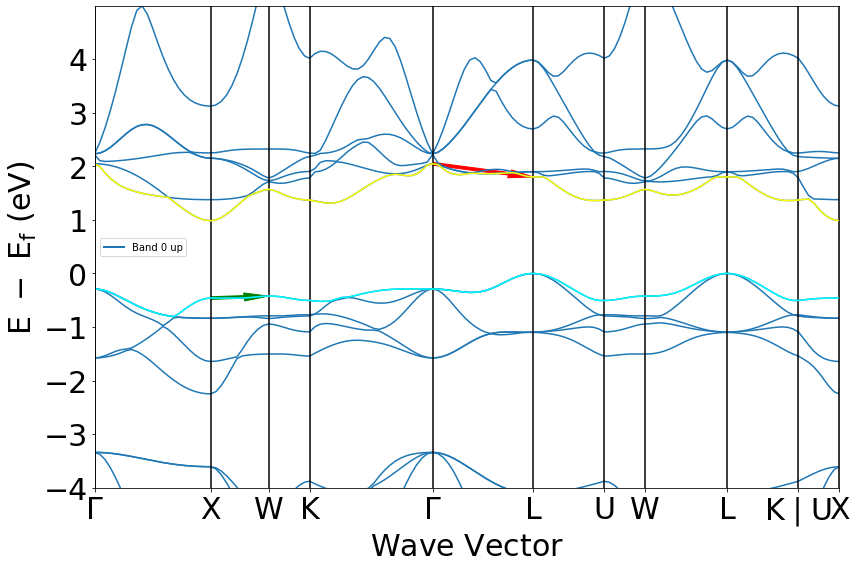

In [41]:
bandplot.get_plot()
conddx = condup[condmin][2] - condup[condmin][0]
conddy = condup[condmin][3] - condup[condmin][1]
valdx = valencep[valmin][2] - valencep[valmin][0]
valdy = valencep[valmin][3] - valencep[valmin][1]

for i in range(len(distances)):
    plt.plot(distances[i],energy.get('1')[i][14],'cyan')
    plt.plot(distances[i],energy.get('1')[i][15],'yellow')

plt.arrow(condup[condmin][0],condup[condmin][1], conddx, conddy, color='red',width = 0.05,length_includes_head =True)
plt.arrow(valencep[valmin][0],valencep[valmin][1], valdx, valdy, color='green',width = 0.05,length_includes_head =True)

#### Analyse du graphe obtenu : 

### 3) Calcul des masses effectives au sommet (base) de la dernière (première) bande de valence (conduction) en supposant une dispersion parabolique.

Il faut calculer la masse effective $m^*$ en utilisant la formule: $m^* = \hbar^{2} (\frac{\partial^2 E} {\partial^2 k})^{-1}$

Or dans notre cas, on suppose une dispersion parabolique de l'énergie. Il faut donc faire une interpolation afin de connaitre l'expression de l'énergie $E$ aux points qui nous intéressent à savoir au VBM pour la bande de valence et au CBM pour la bande de conduction.

Ensuite, il suffira de dériver deux fois cette expression en fonction du vecteur d'onde $k$ et de l'injecter dans l'expression de la masse effective pour avoir la solution.

In [77]:
#Détermination des constantes utiles :
hbar = (6.62607015*10**(-34))/(2*np.pi*1.602176634*10**(-19)) ##en eV 

In [78]:
#Interpolation de l'énergie suivant une dispersion parabolique

vbms = data.get('vbm')
cbms = data.get('cbm')

##Déterminer les 3 points qui serviront pour l'interpolation en partant du VBM, 
##on regarde la dernière bande de valence (bande 14)
K_val = np.zeros(3)
E_val = np.zeros(3)

##On cherche des points voisins du VBM pour K_val[0] et K_val[2]
K_val[0] = distances [4] [-2]
K_val[1] = vbms[0][0]
K_val[2] = distances [5] [1]


E_val[0] = energy.get('1')[4][14][-2]
E_val[1] = vbms[0][1]
E_val[2] = energy.get('1')[5][14][1]

##Déterminer les 3 points qui serviront pour l'interpolation en partant du CBM, 
##on regarde la première bande de conduction (bande 15)
K_cond = np.zeros(3)
E_cond = np.zeros(3)

##On cherche des points voisins du CBM pour K_cond[0] et K_cond[2]
K_cond[0] = distances [0] [-2]
K_cond[1] = cbms[0][0]
K_cond[2] = distances [1] [1]


E_cond[0] = energy.get('1')[0][15][-2]
E_cond[1] = cbms[0][1]
E_cond[2] = energy.get('1')[1][15][1]

#### Représentation des interpolations :

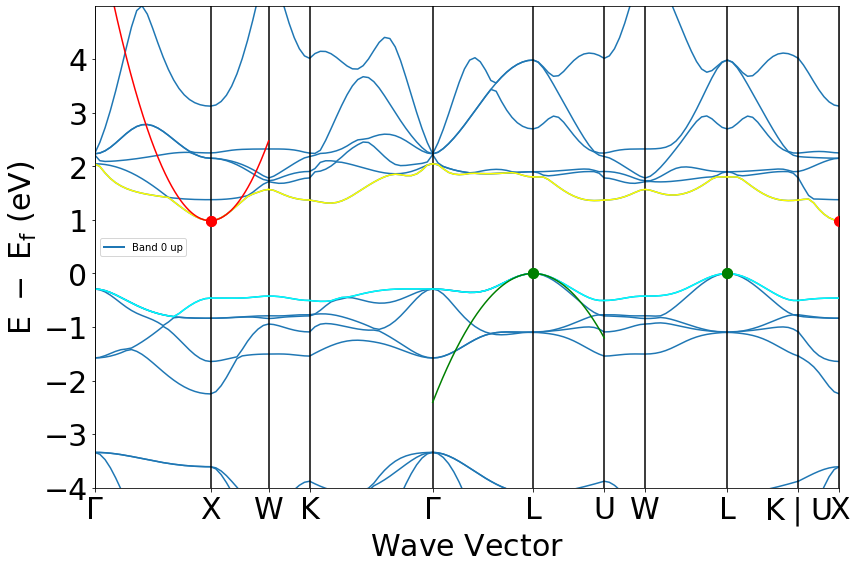

In [101]:
bandplot.get_plot()
#Représentation de la dernière bande de valence et de la première bande de conduction
for i in range(len(distances)):
    plt.plot(distances[i],energy.get('1')[i][14],'cyan')
    plt.plot(distances[i],energy.get('1')[i][15],'yellow')
#Représentation des vbms
for j in range(len(vbms)):
    x, y= vbms[j]
    plt.plot(x, y, 'og', markersize=10)
#Représentation des cbms
for k in range(len(cbms)):
    x, y = cbms[k]
    plt.plot(x ,y ,'or',markersize=10)
    
#Plot de l'interpolation quadratique pour la bande de valence 
f_valbm = np.polyfit(K_val, E_val, 2) 
absval = np.linspace(distances[4][0],distances[5][-1],1000)
plt.plot(absval,np.polyval(f_valbm,absval),'g')

#Plot de l'interpolation quadratique pour la bande de conduction
f_condbm = np.polyfit(K_cond, E_cond, 2)
abscond = np.linspace(distances[0][0],distances[1][-1],1000)
plt.plot(abscond,np.polyval(f_condbm,abscond),'r')

#### Calcul de la masse effective pour la dernière bande de valence 

In [103]:
print("La parabole verte interpolant la dernière bande de valence au VBM est")
print(f_valbm[0],"k²+",f_valbm[1],"k+",f_valbm[2])

d2E_val = 2*f_valbm[0]
m_val = (hbar**2)/d2E_val
print("La masse effective pour la la dernière bande de valence est m_eff = ",m_val,"[kg]")

La parabole verte interpolant la dernière bande de valence au VBM est
-2.8118650206538507 k²+ 22.70435309085331 k+ -45.83147171899159
La masse effective pour la la dernière bande de valence est m_eff =  -7.703836725640531e-32 [kg]


#### Calcul de la masse effective pour la première bande de conduction

In [104]:
print("La parabole rouge interpolant la dernière bande de conduction au CBM est")
print(f_condbm[0],"k²+",f_condbm[1],"k+",f_condbm[2])

d2E_cond = 2*f_condbm[0]
m_cond = (hbar**2)/d2E_cond
print("La masse effective pour la première bande de conduction est m_eff = ",m_cond,"[kg]")

La parabole rouge interpolant la dernière bande de conduction au CBM est
5.134868523671526 k²+ -10.922240989788458 k+ 6.793201399727602
La masse effective pour la première bande de conduction est m_eff =  4.218637519888877e-32 [kg]
